# Analyse Order 2 order 1 and recalibrate

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : June 8th  2022

### 


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

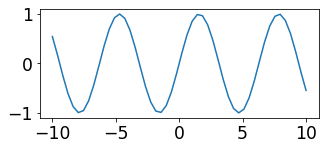

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-06-15'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines,calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy import interpolate
from scipy.signal import savgol_filter

In [12]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [13]:
from time import sleep

In [14]:
from astropy.time import Time
import astropy.units as u

In [15]:
DCCD   = 181.45 # mm
#DCCD   = 200.0 # mm
PIXELW = 0.01   # mm (10 microns)
GAINCORRECTIONFACTOR = 1.025

## Dispersion relation X - wavelength
$$
x = D \frac{N_{eff} \lambda p}{\sqrt{1-(N_{eff} \lambda p)^2}}
$$

In [16]:
def Dispersion(wl,neff,D,p=1):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : number of lines per mm
    - D  : Distance CCD-Hologram per mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in mm and lambdas in mm
    """
    X=D*neff*wl*p/np.sqrt(1-(wl*neff*p)**2)
    return X


## Dispersion rate dX/d lambda
$$
\frac{dx}{d\lambda} = D N_{eff} p \frac{\sqrt{1-(N_{eff}\lambda p)^2} + \frac{(N_{eff} \lambda p)^2}{\sqrt{1-(N_{eff} \lambda p)^2} }}{1-(N_{eff} \lambda p)^2} 
$$

$$
\frac{dx}{d\lambda} = \frac{D N_{eff} p}{\left(1-(N_{eff} \lambda p)^2\right)^{\frac{3}{2}}} 
$$

In [17]:
def Dispersion_Rate(wl,neff,D,p=1):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : nb lines per mm 
    - D  : Distance CCD-Hologram in mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in mm and lambdas in mm
    
    """
    #dxdlambda=D*neff*p*(np.sqrt(1-(wl*neff*p)**2)+ (wl*neff*p)**2/np.sqrt(1-(wl*neff*p)**2))/(1-(wl*neff*p)**2)
    dxdlambda=D*neff*p/(np.sqrt(1-(wl*neff*p)**2))**3
    return dxdlambda 

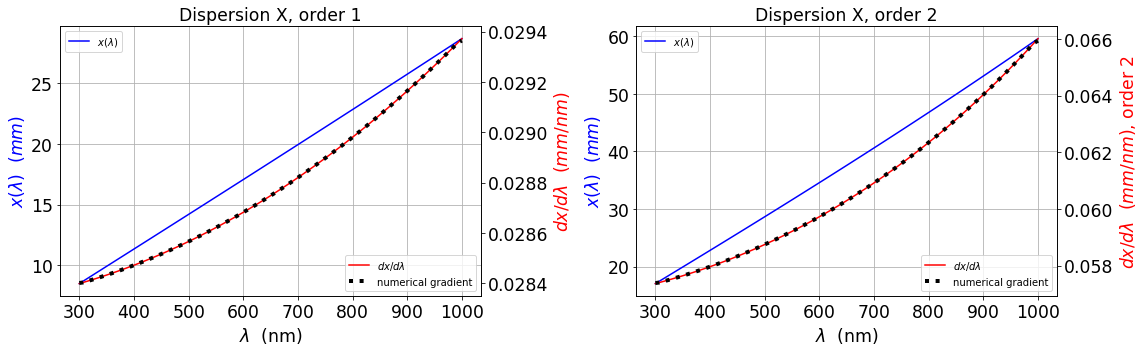

In [18]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

WL=np.linspace(300.,1000.,100)
neff=156. # lines per mm
D=184.45 # mm

Y1=Dispersion(WL*1e-6,neff,DCCD)
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X, order 1")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)*1e-6 ## mm per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/ nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()


ax3 = fig.add_subplot(1,2,2)

Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")
ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax3.set_title("Dispersion X, order 2")
ax3.legend(loc="upper left")
ax3.grid()


ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)*1e-6 ## mm per nm
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($mm/ nm$), order 2",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")
#ax2.grid()


plt.tight_layout()


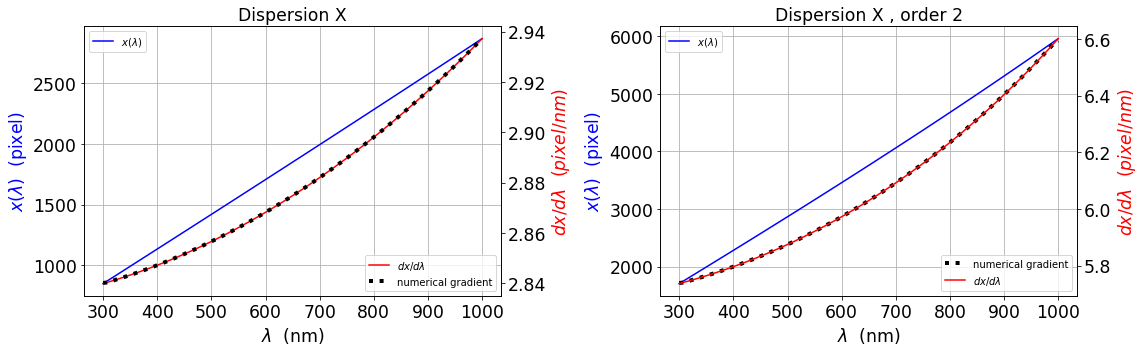

In [19]:
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)

Y1=Dispersion(WL*1e-6,neff,DCCD)/PIXELW   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)/PIXELW*1e-6   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()



ax3 = fig.add_subplot(1,2,2)


Y3=Dispersion(WL*1e-6,neff,DCCD,p=2)/PIXELW   # pixel
ax3.plot(WL,Y3,"b",label="$x(\lambda)$")

ax3.set_xlabel("$\lambda$  (nm)")
ax3.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax3.set_title("Dispersion X , order 2")
ax3.legend(loc="upper left")
ax3.grid()

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

Y4=Dispersion_Rate(WL*1e-6,neff,DCCD,p=2)/PIXELW*1e-6   # pixel per nm
ax4.plot(WL,np.gradient(Y3,WL),"k:",lw=4,label="numerical gradient")
ax4.plot(WL, Y4,"r",label="$dx/d\lambda$")
ax4.set_xlabel("$\lambda$  (nm)")
ax4.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax4.legend(loc="lower right")

plt.tight_layout()

## Multiplicative factor

$$
\frac{\left(\frac{dx}{d\lambda}\right)_{order =2}}{\left(\frac{dx}{d\lambda}\right)_{order =1}}
$$

Text(0.5, 1.0, 'Multiplicative factor order 2/order1 ')

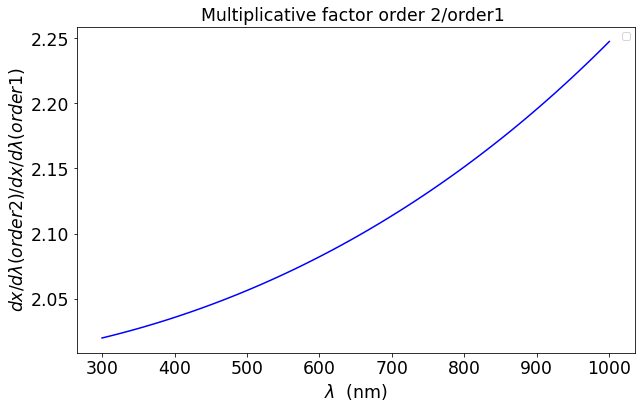

In [20]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(1,1,1)
latexlabel = "$\frac{\left(\frac{dx}{d\lambda}\right)_{order=2}}{\left(\frac{dx}{d\lambda}\right)_{order=1}}$"
ax1.plot(WL,Y4/Y2,"b-")
ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$dx/d\lambda(order2) / dx/d\lambda(order 1) $")
ax1.legend()
ax1.set_title("Multiplicative factor order 2/order1 ")

In [21]:
f_o2o1=interpolate.interp1d(WL,Y4/Y2,bounds_error=False,fill_value="extrapolate")

# Config

- spectrum need config

In [22]:
load_config("../runspectractor_standalone/2022_05/config/auxtel_config_holo_DECONVOLUTION_PSF1D.ini")

No rebinning: parameters.REBIN is forced to 1.


In [23]:
# path index for each month
DATE="20211104"

# Calibration lines

In [24]:
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

In [25]:
my_calib_lines_etador = Lines([HBETA,HGAMMA,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_mucol = Lines([HBETA,HGAMMA,HGAMMA2,HDELTA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd205905 = Lines([HBETA,HGAMMA,HBETA2,HGAMMA2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd009051 = Lines([HBETA,HGAMMA],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd38949 = Lines([HBETA,HGAMMA],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
my_calib_lines_hd031128 = Lines([HBETA,HGAMMA],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Input file

/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec

In [26]:
top_path = "/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D"

In [27]:
#! ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104

In [28]:
exposure ="2021110400508"  # ETADOR

#exposure = "2021110400263"  # HD205905
#exposure = "2021110400274"   # HD009051 , creazy results

#exposure = "2021110400519"  # HD38949
#exposure = "2021110400542"   # HD031128
#exposure = "2021110400553"    #Mu Col
#exposure = "2021110400564"   # HD38949



In [29]:
path=os.path.join(os.path.join(top_path,DATE),exposure)

In [30]:
path_subdir=os.path.join(path,"basespec")

In [31]:
all_files = sorted(os.listdir(path_subdir))

In [32]:
all_files 

['exposure_2021110400508_postisrccd_lines.csv',
 'exposure_2021110400508_postisrccd_spectrogram.fits',
 'exposure_2021110400508_postisrccd_spectrum.fits',
 'exposure_2021110400508_postisrccd_table.csv']

# Read

## Read Spectrum

In [33]:
spectrum = Spectrum(file_name=os.path.join(path_subdir,all_files[2]))

set date_obs to 2021-11-05T04:49:33.916
set expo to 20.0
set airmass to 1.41214447333932
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -66.0397222222222
set hour_angle to -45.38165160354449
set temperature to 5.6
set pressure to 740.35
set humidity to 37.0
set lambda_ref to 572.0006264477072
set parallactic_angle to -60.35656136093252
target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1


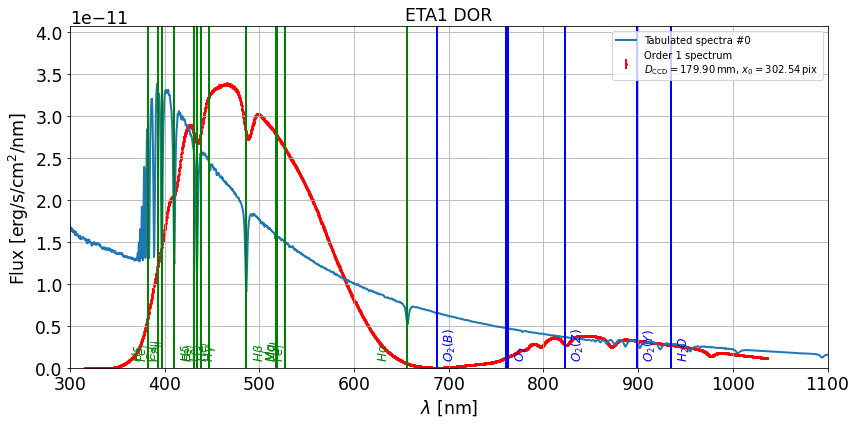

In [34]:
spectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True)

# Recalibrate

2022-06-15 16:05:37  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.


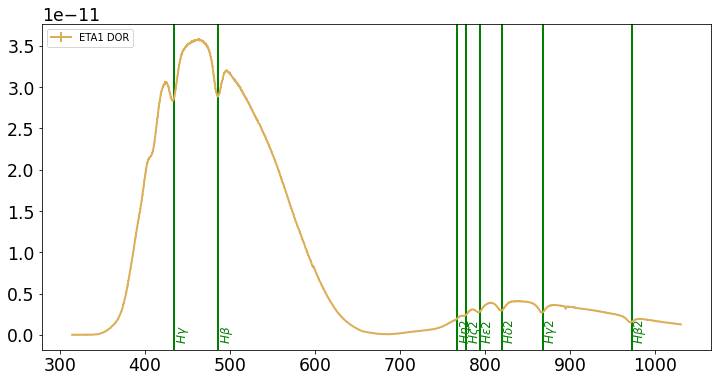

In [35]:
import seaborn as sns
color_list = sns.color_palette("hls",10)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
idx=1
targetname = spectrum.target.label
if targetname == "ETA1 DOR":
    spectrum.lines = my_calib_lines_etador 
    calibrate_spectrum(spectrum, with_adr=False)
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    spectrum.lines.plot_atomic_lines(ax=ax)
if targetname == "mu. Col":
    spectrum.lines = my_calib_lines_mucol 
    calibrate_spectrum(spectrum, with_adr=False)
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    spectrum.lines.plot_atomic_lines(ax=ax)
if targetname == "HD205905":
    spectrum.lines = my_calib_lines_hd205905 
    calibrate_spectrum(spectrum, with_adr=False)
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    spectrum.lines.plot_atomic_lines(ax=ax)
if targetname == "HD009051":
    spectrum.lines = my_calib_lines_hd009051 
    calibrate_spectrum(spectrum, with_adr=False)
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    spectrum.lines.plot_atomic_lines(ax=ax)
if targetname == "HD38949":
    spectrum.lines = my_calib_lines_hd38949 
    calibrate_spectrum(spectrum, with_adr=False)
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    spectrum.lines.plot_atomic_lines(ax=ax)
if targetname == "HD031128":
    spectrum.lines = my_calib_lines_hd031128  
    calibrate_spectrum(spectrum, with_adr=False)
    ax.errorbar(spectrum.lambdas, spectrum.data, yerr=spectrum.err, color=color_list[idx],label=spectrum.target.label,lw=2)
    spectrum.lines.plot_atomic_lines(ax=ax)
ax.legend()        

In [36]:
spectrum.target.label

'ETA1 DOR'

- $S_\lambda(\lambda)$ : SED in erg/cm2/s/nm
- FLAM to ADU
$$
\frac{dN_{ADU}(\lambda)}{dN_{pix}} = \left( \frac{S \Delta T \epsilon_{eq}(\lambda)}{G_{el}} \right) \frac{1}{hc} \lambda \frac{d\lambda}{dN_{pix}} \cdot S_\lambda(\lambda)
$$

- ADU to FLAM

$$
S_\lambda(\lambda) = \frac{dn_\gamma(\lambda)}{d\lambda} = \frac{G_{el}}{S\Delta T \epsilon_{QE}(\lambda)} (hc) \frac{1}{\lambda} \left( \frac{dN_{pix}}{d\lambda}\right) \left(\frac{dN_{ADU}}{dN_{pix}} \right)
$$


- FLAM to ADU constant:
$$
FLAM\_TO\_ADURATE = \left( \frac{S}{G_{el}} \right) \frac{1}{hc} \times \left[ TIME \right ]_{unit}  \times \left[ \lambda d\lambda \right]_{unit}
\times \left[ SED \right ]_{unit} 
$$

# Disperser

In [37]:
spectrum.x0

[302.23102961024546, 1754.496653072347]

In [38]:
spectrum.order

1

In [39]:
spectrum.disperser.full_name

'Phase hologram #4-003'

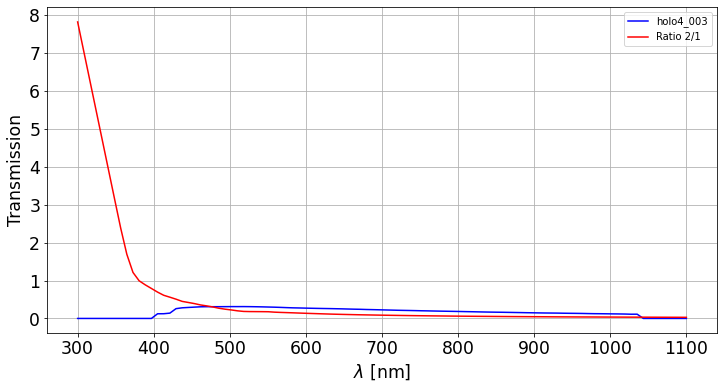

In [40]:
spectrum.disperser.plot_transmission()

In [41]:
spectrum.disperser.N([2000.,300.])

156

In [42]:
spectrum.disperser.load_specs()

In [43]:
my_distance=np.arange(0,6500)

In [44]:
spectrum.order

1

In [45]:
spectrum.x0

[302.23102961024546, 1754.496653072347]

## Check dispersion relation

In [46]:
neff0 = 156
DCCD0 = 181.45 

In [47]:
f = 1.0

In [48]:
neff = neff0*f
DCCD = DCCD0/f

In [49]:
my_lambdas = spectrum.disperser.grating_pixel_to_lambda(my_distance, [0,0], order=spectrum.order)
my_lambdas2 = spectrum.disperser.grating_pixel_to_lambda(my_distance, [0,0], order=2)

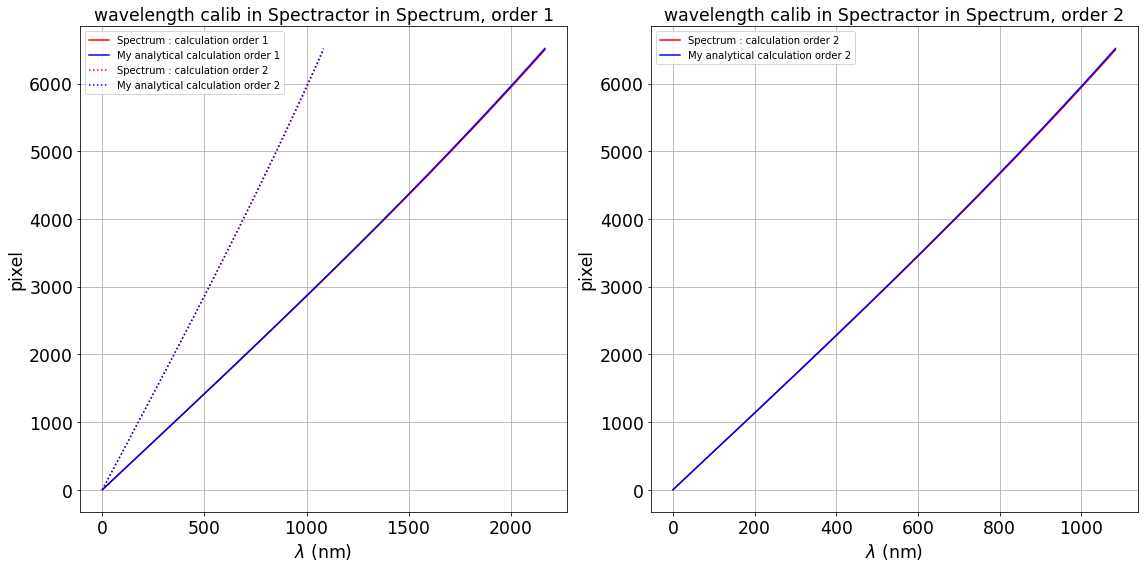

In [50]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
ax.plot(my_lambdas,my_distance,'r-',label="Spectrum : calculation order 1")

x_pix = Dispersion(my_lambdas*1e-6,neff,DCCD)/PIXELW   # pixel 
x_pix2 = Dispersion(my_lambdas2*1e-6,neff,DCCD,p=2)/PIXELW   # pixel 


ax.plot(my_lambdas,x_pix,'b-',label="My analytical calculation order 1")
ax.plot(my_lambdas2,my_distance,'r:',label="Spectrum : calculation order 2")
ax.plot(my_lambdas2,x_pix2,'b:',label="My analytical calculation order 2")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("pixel")
ax.grid()
ax.legend()
ax.set_title("wavelength calib in Spectractor in Spectrum, order 1")

ax2=fig.add_subplot(122)
ax2.plot(my_lambdas2,my_distance,'r-',label="Spectrum : calculation order 2") 

ax2.plot(my_lambdas2,x_pix2,'b-',label="My analytical calculation order 2")
ax2.set_xlabel("$\\lambda$ (nm)")
ax2.set_ylabel("pixel")
ax2.grid()
ax2.legend()
ax2.set_title("wavelength calib in Spectractor in Spectrum, order 2")
plt.tight_layout()

## Check dispersion rate relation

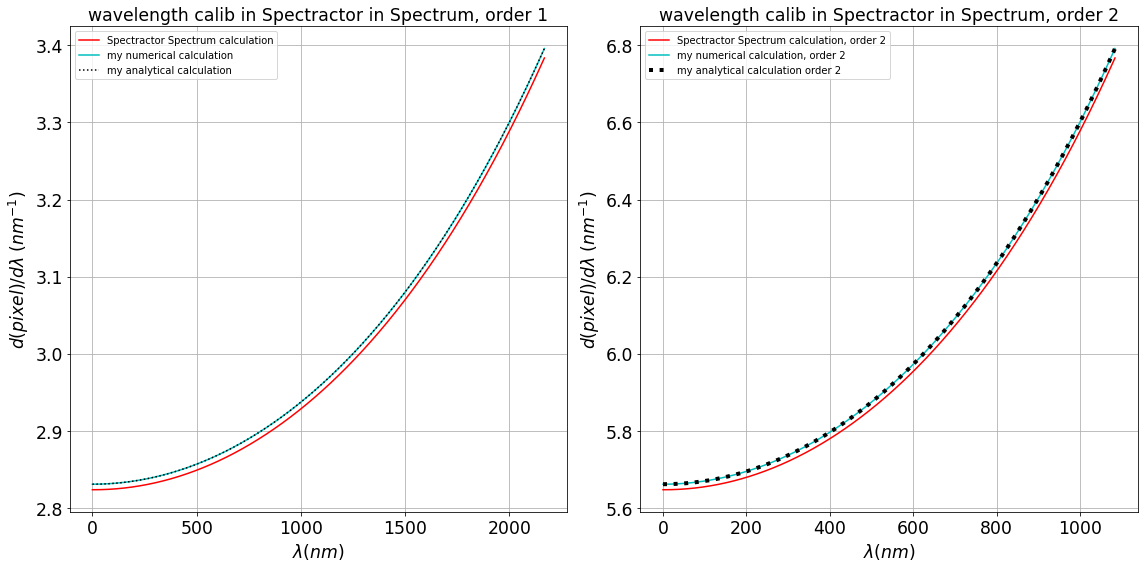

In [51]:
fig=plt.figure(figsize=(16,8))
ax=fig.add_subplot(121)
ax.plot(my_lambdas,np.gradient(my_distance,my_lambdas),'r-',label="Spectractor Spectrum calculation")
ax.plot(my_lambdas,np.gradient(x_pix,my_lambdas),'c-',label="my numerical calculation")
ax.plot(my_lambdas,Dispersion_Rate(my_lambdas*1e-6,neff,DCCD)/PIXELW*1e-6,"k:",label="my analytical calculation") 
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.set_xlabel("$\lambda (nm)$")
ax.grid()
ax.set_title("wavelength calib in Spectractor in Spectrum, order 1")
ax.legend()


ax1=fig.add_subplot(122)
ax1.plot(my_lambdas2,np.gradient(my_distance,my_lambdas2),'r-',label="Spectractor Spectrum calculation, order 2")
ax1.plot(my_lambdas2,np.gradient(x_pix2,my_lambdas2),'c-',label="my numerical calculation, order 2")
ax1.plot(my_lambdas2,Dispersion_Rate(my_lambdas2*1e-6,neff,DCCD,p=2)/PIXELW*1e-6,"k:",lw=4,label="my analytical calculation order 2") 
ax1.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax1.set_xlabel("$\lambda (nm)$")
ax1.grid()
ax1.set_title("wavelength calib in Spectractor in Spectrum, order 2")
ax1.legend()
plt.tight_layout()

## ratios dN/dlambdas

In [52]:
f_dndx_order1_mymodel =  interpolate.interp1d(my_lambdas,np.gradient(x_pix,my_lambdas),bounds_error=False,fill_value="extrapolate") 
f_dndx_order1_spectractor = interpolate.interp1d(my_lambdas,np.gradient(my_distance,my_lambdas),bounds_error=False,fill_value="extrapolate") 
f_dndx_order2_mymodel =  interpolate.interp1d(my_lambdas2,np.gradient(x_pix2,my_lambdas2),bounds_error=False,fill_value="extrapolate") 
f_dndx_order2_spectractor = interpolate.interp1d(my_lambdas2,np.gradient(my_distance,my_lambdas2),bounds_error=False,fill_value="extrapolate") 

In [53]:
WL3 = np.arange(1,1100)
f_dndx_order21ratio_mymodel = interpolate.interp1d(WL3,f_dndx_order2_mymodel(WL3)/f_dndx_order1_mymodel(WL3),bounds_error=False,fill_value="extrapolate") 
f_dndx_order21ratio_spectractor = interpolate.interp1d(WL3,f_dndx_order2_spectractor(WL3)/f_dndx_order1_spectractor(WL3),bounds_error=False,fill_value="extrapolate") 

Text(0.5, 1.0, '$d(pixel)/d\\lambda$ ratio (order-2/order-1)')

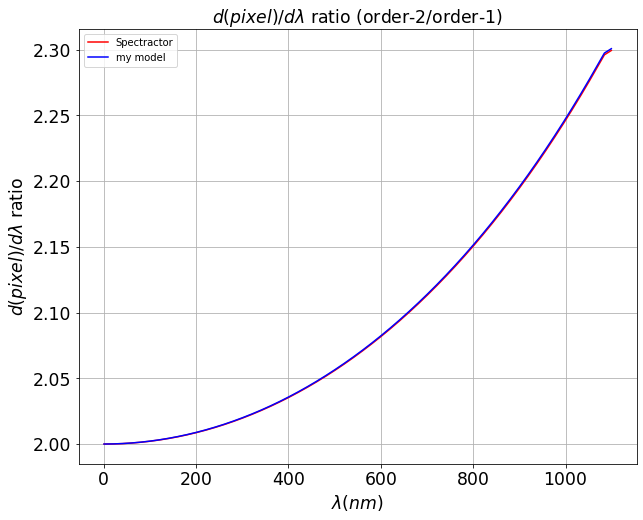

In [54]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)

ax.plot(WL3,f_dndx_order21ratio_spectractor(WL3),"r-",label="Spectractor")
ax.plot(WL3,f_dndx_order21ratio_mymodel(WL3),"b-",label="my model" )

ax.set_ylabel("$d(pixel)/d\lambda$ ratio")
ax.set_xlabel("$\lambda (nm)$")
ax.grid()
ax.legend()
ax.set_title("$d(pixel)/d\lambda$ ratio (order-2/order-1)")

In [55]:
WLCUT = 670

In [56]:
WL=np.arange(350.,520.)

## Compute ratio with Spectrum

In [57]:
order1_idx_s = np.where(spectrum.lambdas<WLCUT)
order2_idx_s = np.where(spectrum.lambdas>WLCUT)

In [58]:
wl1_s = spectrum.lambdas[order1_idx_s] 
flux1_s= spectrum.data[order1_idx_s] 
flux1err_s= spectrum.err[order1_idx_s] 

- order 2 is dispersed with $p=2$, then $\lambda \rightarrow \lambda_{position}/2$
- light for order 2 is dispersed on  twice pixel size, and when one convert ADU rate into FLAM we divide the ADU rate by the factor $(p\lambda) d(p \lambda)$

In [59]:
wl2_s = spectrum.lambdas[order2_idx_s]/2. 
flux2_s= spectrum.data[order2_idx_s]*(f_dndx_order21ratio_spectractor(wl2_s))**2
flux2err_s = spectrum.err[order2_idx_s]*(f_dndx_order21ratio_spectractor(wl2_s))**2

Text(0.5, 1.0, 'Fluxes : order 1 & 2')

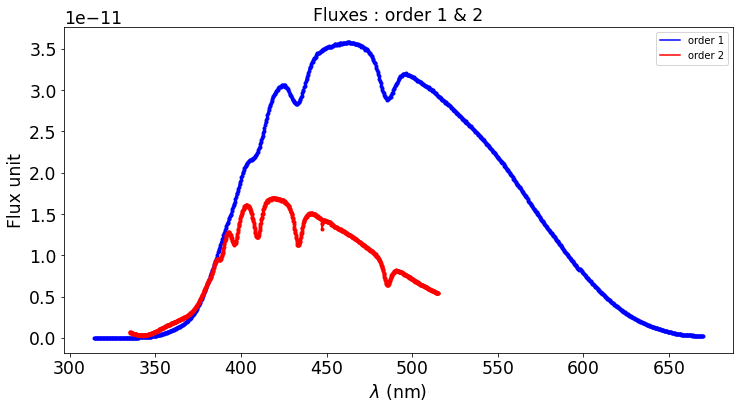

In [60]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wl1_s,flux1_s,"b",label="order 1")
ax.errorbar(wl1_s,flux1_s,yerr=flux1err_s,color="b",ecolor="grey",marker=".")

ax.plot(wl2_s,flux2_s,"r",label="order 2")
ax.errorbar(wl2_s,flux2_s,yerr=flux2err_s,color="r",ecolor="grey",marker=".")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux unit")
ax.set_title("Fluxes : order 1 & 2")

Text(0.5, 1.0, 'Flux error : order 1 & 2')

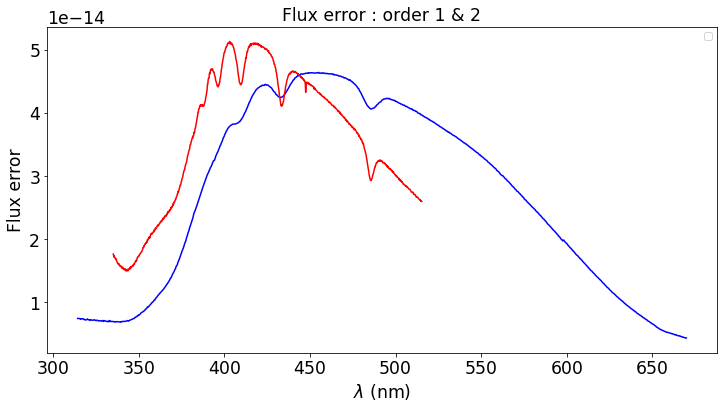

In [61]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wl1_s,flux1err_s,'b-')
ax.plot(wl2_s,flux2err_s,'r-')
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux error")
ax.set_title("Flux error : order 1 & 2")

In [62]:
f1_s=np.interp(WL,wl1_s,flux1_s)
f2_s=np.interp(WL,wl2_s,flux2_s)
f1err_s=np.interp(WL,wl1_s,flux1err_s)
f2err_s=np.interp(WL,wl2_s,flux2err_s)

In [63]:
ratio_s = f2_s/f1_s/GAINCORRECTIONFACTOR
ratioerr_s = (f1_s*f2err_s+ f2_s*f1err_s)/f1_s**2
ratio_filtered_s = savgol_filter(ratio_s, 25, 3) # window size 51, polynomial order 3

(0.0, 5.0)

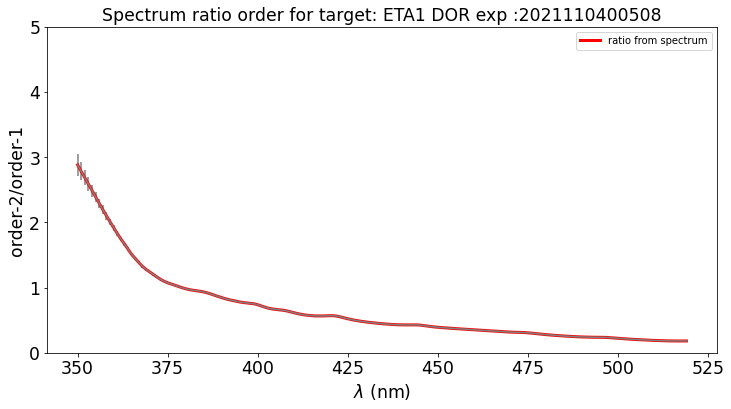

In [64]:
fig=plt.figure()
ax=fig.add_subplot(111)
#ax.plot(WL,ratio_filtered_t ,'b',label="ratio from table",alpha=0.1)
ax.errorbar(WL,ratio_filtered_s,yerr=ratioerr_s ,color='grey')
ax.plot(WL,ratio_filtered_s ,color='r',label="ratio from spectrum",lw=3)
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("order-2/order-1")
ax.legend()
ax.set_title(f"Spectrum ratio order for target: {spectrum.target.label} exp :{exposure}")
ax.set_ylim(0,5.)

# Save order2/order1 in file

In [65]:
exposure

'2021110400508'

In [66]:
filename_out = "order2order1_" + exposure + "_recalib.csv" 

In [67]:
filename_out

'order2order1_2021110400508_recalib.csv'

In [68]:
df_out = pd.DataFrame()

In [69]:
df_out["lambdas"]   = WL
df_out["ratioo2o1"] = ratio_filtered_s
df_out["ratioo2o1err"] = ratioerr_s 

In [70]:
df_out.to_csv(filename_out)